# Room Impulse Response (RIR) Finding
Uses sinusoidal sweep and clapping to determine room RIR

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from os import listdir
from os.path import isfile, join
from scipy.signal import resample
from scipy.signal import convolve, fftconvolve
import pyroomacoustics as pra

In [140]:
# Parameters for the sweep - across human hearing range
f_start = 20      # Start frequency (Hz)
f_end = 20000     # End frequency (Hz)
duration = 20     # Duration of the sweep (seconds)
fs = 48000        # Sampling rate (Hz)

# Time vector
t = np.linspace(0, duration, int(fs * duration))

# Generate the logarithmic sweep
sweep = 0.5*np.sin(2 * np.pi * f_start * duration * ((f_end/f_start)**(t/duration) - 1)/np.log(f_end/f_start))

# Save the sweep to file (optional)
wavfile.write('../input_samples/sin_sweep.wav', fs, sweep)

Deconvolution to recover RIR from sweep

/var/folders/_f/h8xwd2k15l36zgym21rpns740000gn/T/ipykernel_92735/124337888.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, audio = wavfile.read(file_str)


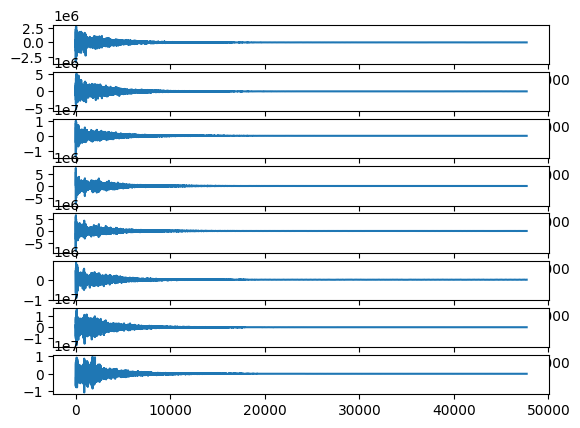

In [141]:
# Load recorded signals for a sine wave sweep test
n_mics = 8
mic_signals_folder = '../array_samples/bf_testing_8_10_24/Sweep Left'
mic_signals_filenames = [f for f in listdir(mic_signals_folder) if isfile(join(mic_signals_folder, f))]
mic_signals_filenames.sort()

for i in range(n_mics):
    file_str = mic_signals_folder + '/' + mic_signals_filenames[i]
    rate, audio = wavfile.read(file_str)

    # ensure sampling rates of all audio matches
    if rate != fs:
        num_samples = int(len(audio) * fs / rate)
        audio = resample(audio, num_samples)

    if i == 0:
        rec_sweep = np.zeros((n_mics, len(audio)))

    # audio = (audio/2**32)
    rec_sweep[n_mics-1-i, :] = audio

# Load raw sine sweep signal
rate, raw_sweep = wavfile.read('../input_samples/sin_sweep.wav')

# Deconvolution: Extract impulse response for each mic
fig, ax = plt.subplots(8)

amplitude = 0.5
w_start = 2*np.pi*f_start/fs
w_end = 2*np.pi*f_end/fs
numSamples = duration*fs
taxis = np.arange(0,numSamples,1)/(numSamples-1)
envelope = (w_end/w_start)**(-taxis)
scaling = np.pi*numSamples*(w_start/w_end-1)/(2*(w_end-w_start)*np.log(w_start/w_end))*(w_end-w_start)/np.pi

for i in range(n_mics):
    inv_filter = np.flipud(raw_sweep)*envelope
    inv_filter = inv_filter/amplitude**2/scaling
    rir = fftconvolve(inv_filter, rec_sweep[i,:])
    rir = rir[1072300:1120000] # trim rir (by hand)

    if i == 0:
        RIRs = np.zeros((n_mics, len(rir)))
    RIRs[i,:] = rir
    ax[i].plot(rir)

/var/folders/_f/h8xwd2k15l36zgym21rpns740000gn/T/ipykernel_92735/1866472842.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, audio = wavfile.read(file_str)


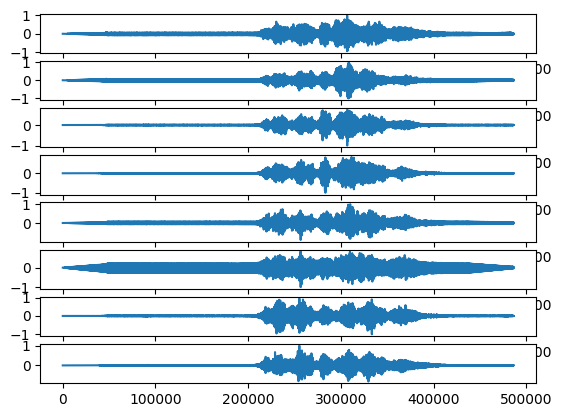

In [142]:
# apply RIRs to mic signals
mic_signals_folder = '../array_samples/bf_testing_8_10_24/Both 1'
mic_signals_filenames = [f for f in listdir(mic_signals_folder) if isfile(join(mic_signals_folder, f))]
mic_signals_filenames.sort()

for i in range(n_mics):
    file_str = mic_signals_folder + '/' + mic_signals_filenames[i]
    rate, audio = wavfile.read(file_str)

    # ensure sampling rates of all audio matches
    if rate != fs:
        num_samples = int(len(audio) * fs / rate)
        audio = resample(audio, num_samples)

    if i == 0:
        mic_vocals = np.zeros((n_mics, len(audio)))

    # audio = (audio/2**32)
    mic_vocals[n_mics-1-i, :] = audio

# Deconvolution: Extract raw signal using RIR
fig, ax = plt.subplots(8)

for i in range(n_mics):
    inv_rir = np.flipud(RIRs[i,:])
    vocal = fftconvolve(inv_rir, mic_vocals[i,:])
    # rir = rir[1107600:1150000] # trim rir (by hand)

    if i == 0:
        vocals = np.zeros((n_mics, len(vocal)))

    vocal_norm = pra.normalize(vocal)
    vocals[i,:] = vocal_norm
    wavfile.write('no_rir_' + str(i+1) + '.wav', fs, vocal_norm)

    ax[i].plot(vocal_norm)

Alternative: using recordings of a clap

/var/folders/_f/h8xwd2k15l36zgym21rpns740000gn/T/ipykernel_92735/3470384327.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, audio = wavfile.read(file_str)


(8, 10500)


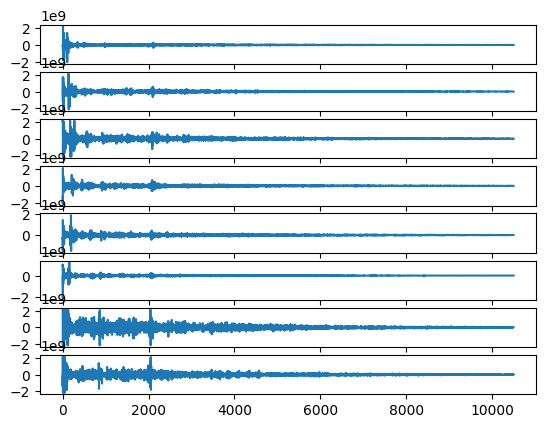

In [143]:
# No deconvolution needed for a clap
mic_signals_folder = '../array_samples/bf_testing_8_10_24/Impulse Centre'
mic_signals_filenames = [f for f in listdir(mic_signals_folder) if isfile(join(mic_signals_folder, f))]
mic_signals_filenames.sort()

fig, ax = plt.subplots(8)

for i in range(n_mics):
    file_str = mic_signals_folder + '/' + mic_signals_filenames[i]
    rate, audio = wavfile.read(file_str)

    # ensure sampling rates of all audio matches
    if rate != fs:
        num_samples = int(len(audio) * fs / rate)
        audio = resample(audio, num_samples)

    if i == 0:
        clap_ir = np.zeros((n_mics, len(audio)))

    clap_ir[n_mics-1-i, :] = audio

clap_ir = clap_ir[:,109500:120000]
print(clap_ir.shape)
for i in range(n_mics):
    ax[i].plot(clap_ir[i,:])

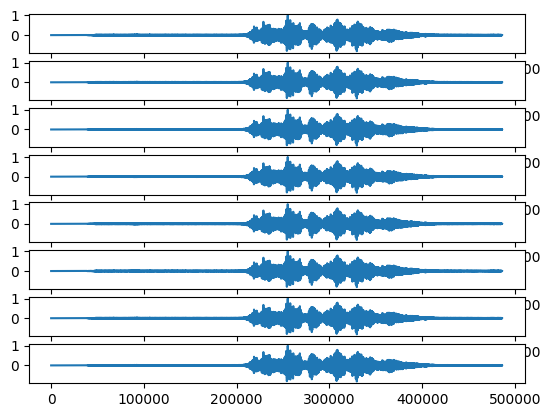

In [144]:
# Deconvolution: Extract raw signal using RIR
fig, ax = plt.subplots(8)

for i in range(n_mics):
    inv_rir = np.flipud(clap_ir[i,:])

    if i == 0:
        vocals = np.zeros((n_mics, len(vocal)))

    vocal_norm = pra.normalize(vocal)
    vocals[i,:] = vocal_norm
    wavfile.write('no_rir_' + str(i+1) + '.wav', fs, vocal_norm)

    ax[i].plot(vocal_norm)